In [1]:
import pandas as pd
import os, re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Specify the experiment type, i.e., 0: load stimulus, 1: resource stimulus
exp_type = 0

In [3]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [4]:
chdir = True

In [5]:
# Metadata for specific SFC configurations
exp_ls = "exp10"
exp_rs = "exp-4-1-1"
vnfs = ["firewall.csv", "nf_router.csv", "ndpi_stats.csv", "payload_scan.csv", "bridge.csv"]

In [6]:
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [7]:
# this function is good for long_exp

def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("..\\dag-1\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for line in lines:
                value = float(line.strip()) /1000
                tmp.append(value)
                
    else:
        with open(os.path.join("..\\dag-1\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = "N/A"
                tmp.append(value)
                
    return tmp

In [8]:
# this function is good for exp1-exp10, pay attention the latency feature
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("..\\dag-1\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for i in range(len(lines)):
                if i % 2 != 0:  # Check if the index is odd
                    value = float(lines[i].strip()) / 1000
                    tmp.append(value)
    else:
        with open(os.path.join("..\\dag-1\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = "N/A"
                tmp.append(value)
                
    return tmp

In [9]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join("..\\dag-1\\data", exp_type, exp_num, file)) as f:
        for line in f:
            if re.search(stat_name, line):
                stat.append(line.strip().split(',')[index])
    
    return list(map(lambda x:float(x), stat[:-1]))


In [10]:
latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
len(latency)

180

In [11]:
tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
len(tx_stats)

179

In [12]:
rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
len(rx_stats)

179

In [13]:
firewall_instructions = parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)
len(firewall_instructions)

178

In [14]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads"]

In [15]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
    
    latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
    #normalized_latency = []
    #for i in range(0, len(latency)):
        #if i % 2:
            #normalized_latency.append(latency[i])
    
    seq_length = min([len(parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)), \
                          len(tx_stats), \
                          len(rx_stats), \
                          len(latency)])
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    for f in features:
        for v in vnfs:
            tmp = parse_reg("load_stimulus", exp_ls, v, f, 1)
            
            dic[v.split(".")[0]+"_"+f.replace(",","")] = tmp[:seq_length]
            
    return pd.DataFrame(dic)

In [16]:
def make_df():
    tmp = []
    dic = dict()

    tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
    latency = parse_seq("load_stimulus", exp_ls, "latency.csv")

    seq_length = min(len(tx_stats), len(rx_stats), len(latency), len(parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)))

    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]

    for f in features:
        for v in vnfs:
            tmp = parse_reg("load_stimulus", exp_ls, v, f, 1)
            tmp = tmp[:seq_length]
            if len(tmp) < seq_length:
                tmp = np.pad(tmp, (0, seq_length - len(tmp)), mode='constant')
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp

    return pd.DataFrame(dic)


In [17]:
df = make_df()
df
# Reset the index starting from 0
df = df.reset_index(drop=True)

<Axes: >

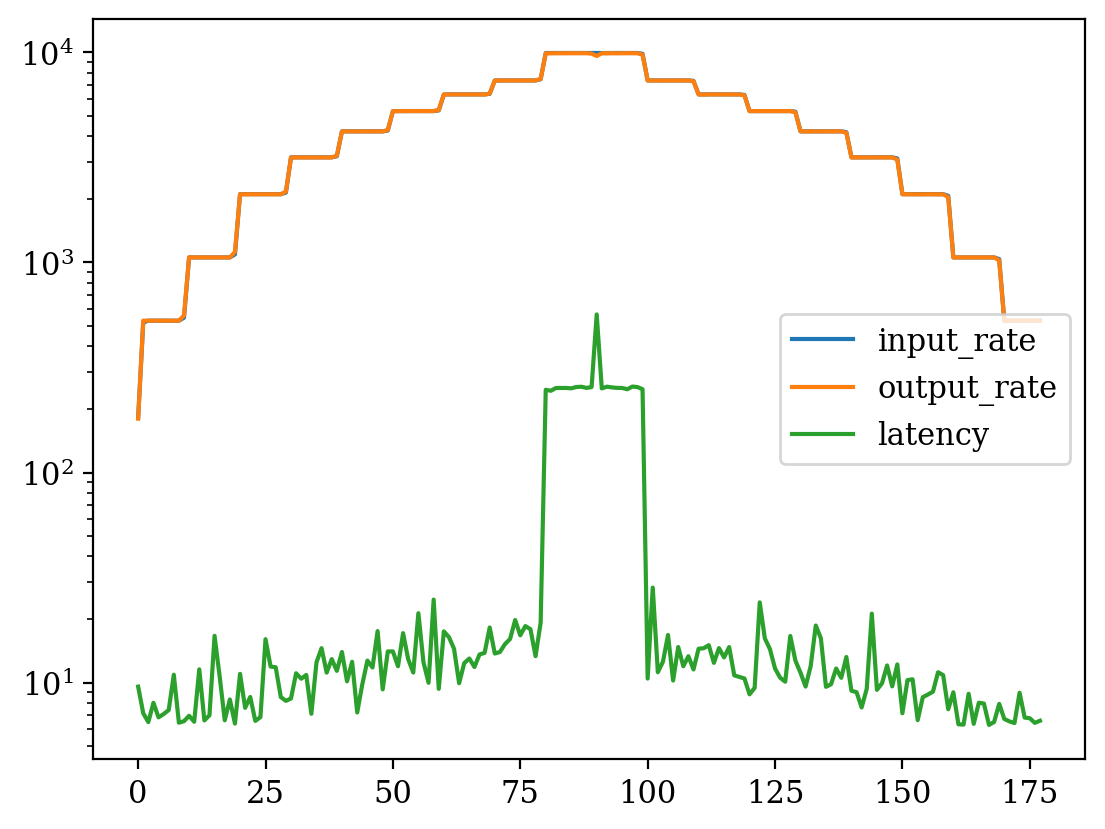

In [18]:
df.iloc[:, :3].plot(logy=True)

In [19]:
abs_path = os.path.join("..\\dag-1\\datasets", "load_stimulus_"+ exp_ls +".csv")
df.to_csv(abs_path, sep=',')

# Resource stimulus

In [20]:
def make_df_rl(exp_rs):
    tmp = []
    dic = dict()

    tx_stats = parse_seq("resource_stimulus", exp_rs, "tx_stats.csv")
    rx_stats = parse_seq("resource_stimulus", exp_rs, "rx_stats.csv")
    latency = parse_seq("resource_stimulus", exp_rs, "latency.csv")
    seq_length = min(len(tx_stats), len(rx_stats), len(latency), len(parse_reg("resource_stimulus", exp_rs, "firewall.csv", "instructions", 1)))

    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]

    for f in features:
        for v in vnfs:
            tmp = parse_reg("resource_stimulus", exp_rs, v, f, 1)
            tmp = tmp[:seq_length]
            if len(tmp) < seq_length:
                tmp = np.pad(tmp, (0, seq_length - len(tmp)), mode='constant')
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp

    return pd.DataFrame(dic)

In [21]:
df_rl = make_df_rl("exp-4-1-1")
df_rl

,input_rate,output_rate,latency,firewall_instructions,nf_router_instructions,ndpi_stats_instructions,payload_scan_instructions,bridge_instructions,firewall_branches,nf_router_branches,...,firewall_LLC-stores,nf_router_LLC-stores,ndpi_stats_LLC-stores,payload_scan_LLC-stores,bridge_LLC-stores,firewall_LLC-loads,nf_router_LLC-loads,ndpi_stats_LLC-loads,payload_scan_LLC-loads,bridge_LLC-loads
0,445.197379,410.469191,10.384,1.004634e+10,9.745856e+09,1.021915e+10,9.764246e+09,9.510672e+09,1.970056e+09,1.932564e+09,...,3104267.0,4517414.0,2516975.0,2478723.0,3143638.0,5336803.0,6429596.0,4830549.0,6573205.0,7420357.0
1,1858.840163,2045.482176,8.886,1.011385e+10,9.656383e+09,1.020831e+10,9.883970e+09,9.526400e+09,1.977517e+09,1.911256e+09,...,3130683.0,4549417.0,2533543.0,2484793.0,3157922.0,5373565.0,6439926.0,4859139.0,6648654.0,7489644.0
2,2112.849312,2110.035705,12.336,1.010222e+10,9.491690e+09,1.020556e+10,9.727465e+09,9.514816e+09,1.959262e+09,1.887116e+09,...,3151979.0,4477855.0,2557109.0,2499754.0,3202890.0,5491236.0,6510117.0,4905132.0,6766633.0,7510681.0
3,2113.084092,2109.388522,9.741,1.009920e+10,9.528161e+09,1.010642e+10,8.501919e+09,9.361431e+09,1.990694e+09,1.892003e+09,...,3144203.0,4367397.0,2522350.0,2478322.0,3226720.0,5488305.0,6454846.0,4875529.0,6737158.0,7527913.0
4,2113.117959,2109.643272,17.913,9.522085e+09,9.607031e+09,1.010444e+10,8.502039e+09,9.369160e+09,1.877326e+09,1.901252e+09,...,3083376.0,4440624.0,2477322.0,2428592.0,3173986.0,5426793.0,6386185.0,4812066.0,6653631.0,7322122.0
5,2113.275644,2110.775355,7.882,1.008326e+10,9.515534e+09,1.000443e+10,8.503488e+09,9.267646e+09,1.989374e+09,1.889742e+09,...,3147891.0,4471511.0,2494396.0,2474306.0,3181776.0,5502164.0,6369086.0,4893998.0,6711195.0,7504101.0
6,2113.000535,2110.731240,14.422,9.997535e+09,9.637914e+09,9.526878e+09,8.418335e+09,9.363793e+09,1.976430e+09,1.908312e+09,...,3130383.0,4348482.0,2436695.0,2468541.0,3132525.0,5411274.0,6255489.0,4856043.0,6606221.0,7384986.0
7,2112.864781,2109.967583,7.507,9.995974e+09,9.625798e+09,9.945898e+09,8.337928e+09,9.328048e+09,1.982769e+09,1.911690e+09,...,2782659.0,3955639.0,2222027.0,2242699.0,2858657.0,5082287.0,5676791.0,4492669.0,6075496.0,6461516.0
8,2113.160469,2111.816664,11.005,9.887906e+09,9.635407e+09,1.000320e+10,8.326206e+09,9.263003e+09,1.962031e+09,1.892606e+09,...,3072098.0,4483736.0,2451406.0,2425632.0,3141977.0,5510328.0,6293944.0,4822634.0,6730816.0,7291582.0
9,2113.244106,2110.062380,11.382,9.989248e+09,9.724684e+09,1.011709e+10,8.415900e+09,9.366577e+09,1.975162e+09,1.905252e+09,...,3084363.0,4517718.0,2501587.0,2422272.0,3186578.0,5465122.0,6423895.0,4804174.0,6633121.0,7332977.0


<Axes: >

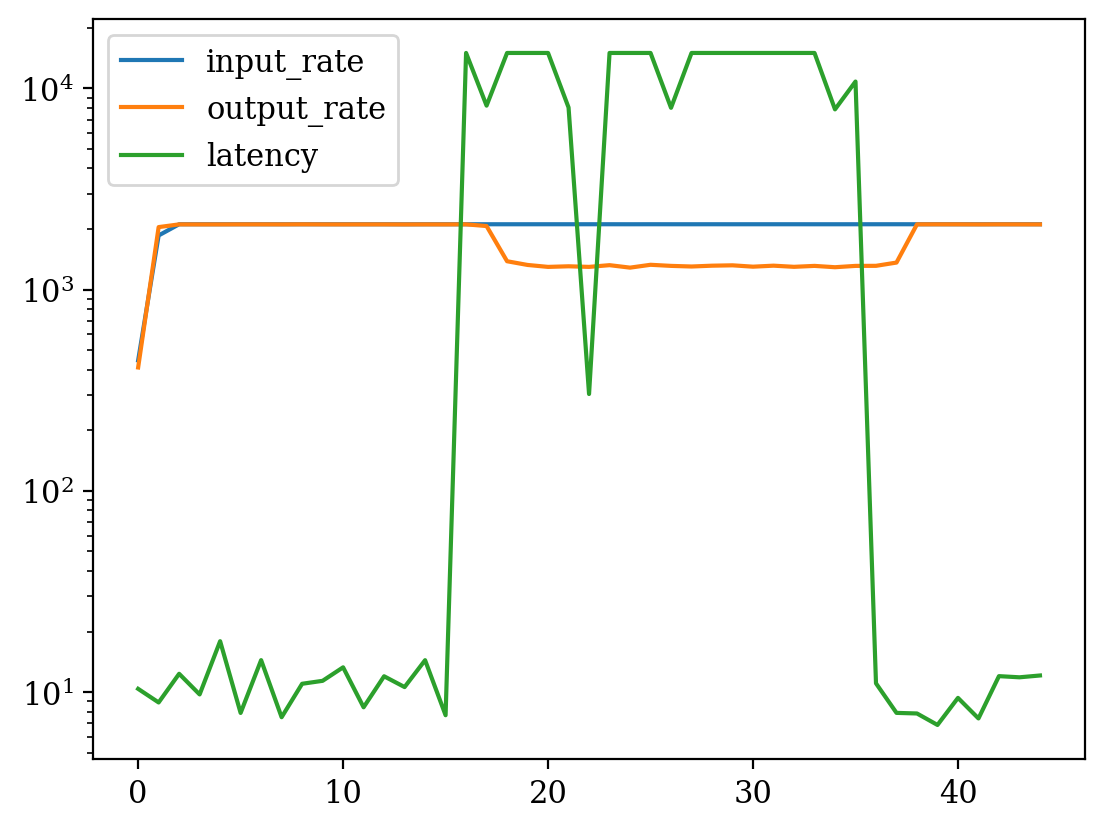

In [22]:
df_rl.iloc[:, :3].plot(logy=True)

In [23]:
exp_rs=["exp-3-1-2","exp-3-1-3","exp-3-1-4","exp-3-1-5","exp-3-3-1","exp-3-3-2","exp-3-3-3","exp-3-3-4","exp-3-3-5","exp-4-1-1","exp-4-1-2","exp-4-1-3","exp-4-1-4","exp-4-1-5","exp-4-3-1","exp-4-3-2","exp-4-3-3","exp-4-3-4","exp-4-3-5","exp-5-1-1","exp-5-1-2","exp-5-1-3","exp-5-1-4","exp-5-1-5","exp-5-3-1","exp-5-3-2","exp-5-3-3","exp-5-3-4","exp-5-3-5","exp-6-1-1","exp-6-1-2","exp-6-1-3","exp-6-1-4","exp-6-1-5","exp-6-3-1","exp-6-3-2","exp-6-3-3","exp-6-3-4","exp-6-3-5","exp-7-1-1","exp-7-1-2","exp-7-1-3","exp-7-1-4","exp-7-1-5","exp-7-3-1","exp-7-3-2","exp-7-3-3","exp-7-3-4","exp-7-3-5"]
print(exp_rs)
for item in exp_rs:
    df_rl = make_df_rl(item) 
    abs_path = os.path.join("..\\dag-1\\datasets", "resource_stimulus_"+ item +".csv")
    df_rl.to_csv(abs_path, sep=',')


['exp-3-1-2', 'exp-3-1-3', 'exp-3-1-4', 'exp-3-1-5', 'exp-3-3-1', 'exp-3-3-2', 'exp-3-3-3', 'exp-3-3-4', 'exp-3-3-5', 'exp-4-1-1', 'exp-4-1-2', 'exp-4-1-3', 'exp-4-1-4', 'exp-4-1-5', 'exp-4-3-1', 'exp-4-3-2', 'exp-4-3-3', 'exp-4-3-4', 'exp-4-3-5', 'exp-5-1-1', 'exp-5-1-2', 'exp-5-1-3', 'exp-5-1-4', 'exp-5-1-5', 'exp-5-3-1', 'exp-5-3-2', 'exp-5-3-3', 'exp-5-3-4', 'exp-5-3-5', 'exp-6-1-1', 'exp-6-1-2', 'exp-6-1-3', 'exp-6-1-4', 'exp-6-1-5', 'exp-6-3-1', 'exp-6-3-2', 'exp-6-3-3', 'exp-6-3-4', 'exp-6-3-5', 'exp-7-1-1', 'exp-7-1-2', 'exp-7-1-3', 'exp-7-1-4', 'exp-7-1-5', 'exp-7-3-1', 'exp-7-3-2', 'exp-7-3-3', 'exp-7-3-4', 'exp-7-3-5']


<Axes: >

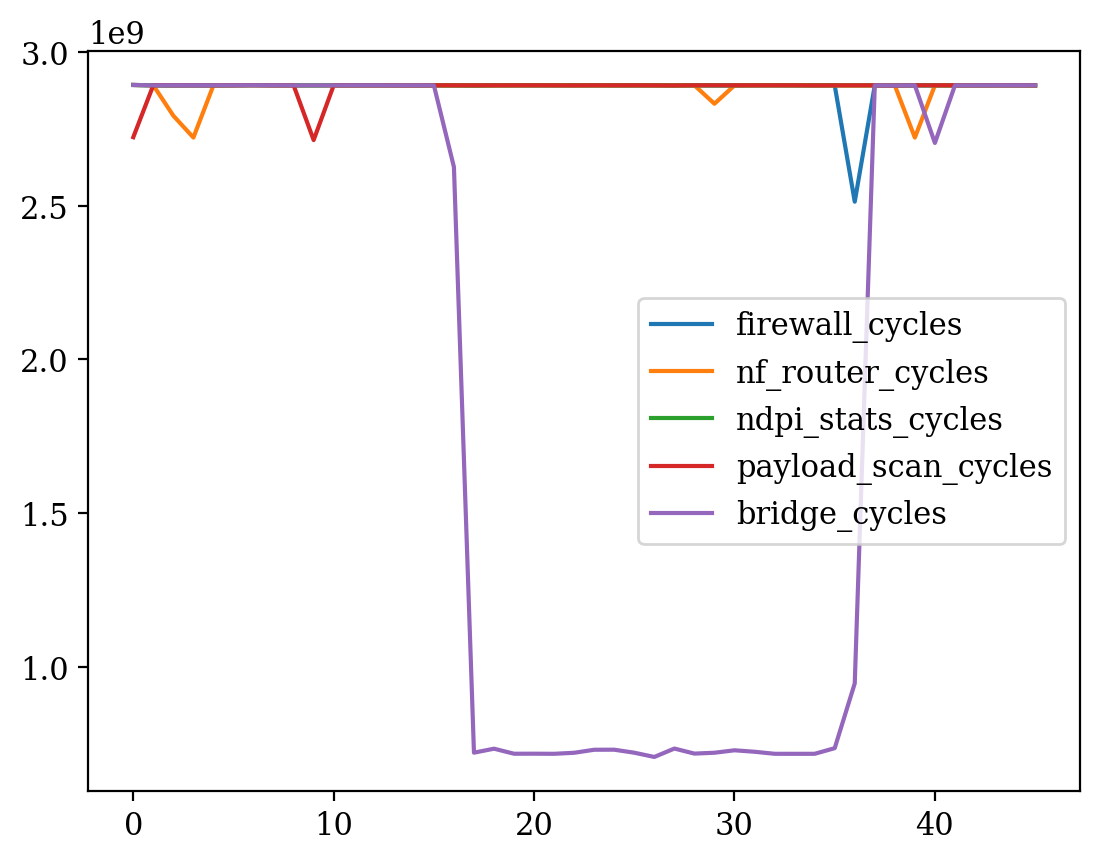

In [24]:
df_rl[["firewall_cycles","nf_router_cycles","ndpi_stats_cycles","payload_scan_cycles","bridge_cycles"]].plot()